In [1]:
# First we load the our survey dataset and relavant packages
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import nltk
from textblob import TextBlob
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim


file_path = "../clean_data.csv"
data = pd.read_csv(file_path)
data.head()



,timestamp,role,frequency_of_travel,primary_purpose,travel_days,travel_hours,ISB_Service_trip_1,bus_stop_board_trip_1,bus_stop_alight_trip_1,day_of_the_week_trip_1,...,additional_features_seats,additional_features_cleanliness,additional_features_comfortable,additional_features_route_coverage,additional_features_updates,issues_with_quality_of_info,special_events,seasonal_changes,seasonal_changes_specific,further_comments
0,10/1/2024 22:17:11,Undergraduate student,Daily,Commute to classes,"Monday, Tuesday, Wednesday, Thursday, Friday","0900 - 1000, 1000 - 1100, 1100 - 1200, 1200 - ...",A2,Opp University Hall,Ventus,Monday,...,4th,6th,5th,2nd,3rd,Yes,3,"No, service is consistent",NaN,More frequent buses during exam periods
1,10/2/2024 1:03:02,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Wednesday, Thursday","0900 - 1000, 1100 - 1200, 1300 - 1400, 1500 - ...",D2,KR MRT,UTown,Monday,...,1st,4th,5th,6th,2nd,No,4,"No, service is consistent",NaN,Bigger bus size
2,10/2/2024 9:18:23,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Wednesday, Thursday","1700 - 1800, 1800 - 1900, 2100 - 2200, 2200 - ...",A2,UHC,S17,Thursday,...,2nd,3rd,4th,5th,6th,No,3,"Yes, service improves/worsens (please specify ...",more in exams,na
3,10/2/2024 13:27:16,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Thursday, Friday, Saturday, Sunday","1100 - 1200, 1200 - 1300, 1800 - 1900, 2100 - ...",A1,PGP Terminal,Opp UHC,Friday,...,2nd,6th,5th,3rd,4th,No,3,"No, service is consistent",NaN,More frequent buses to avoid overcrowding
4,10/2/2024 13:58:50,Undergraduate student,1 - 2 days a week,Commute to classes,"Tuesday, Thursday, Friday","0700 - 0800, 1000 - 1100, 1100 - 1200, 1200 - ...",A1,KR MRT,LT27,Tuesday,...,2nd,6th,5th,3rd,4th,No,1,"Yes, service improves/worsens (please specify ...",worsens during semester break,better capacity management


The next code chunk is a text preprocessing pipeline, designed for a data science or analytics project that involves natural language processing (NLP) tasks. It starts by downloading a set of common English stopwords using the nltk library, which will later be used to filter out non-essential words (like "the," "is," and "in") that don't add much meaning to text analysis. The dataset is then loaded from a CSV file into a pandas DataFrame, specifically extracting a column named further_comments and removing any rows with missing values to ensure that only meaningful, complete entries are included in the analysis. A preprocessing function is defined to clean and standardize the text data further. This function converts the text to lowercase for consistency, removes punctuation to focus only on words, and filters out stopwords, leaving only the most relevant words. This preprocessing prepares the text data for deeper analysis, removing noise and making the data more suitable for NLP tasks like sentiment analysis or topic modeling. The result is a streamlined, standardized text dataset ready for insights and modeling.

In [ ]:

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Extract the relevant text column and preprocess
text_data = data['further_comments'].dropna()  # Replace 'further_comments' with the name of your text column
text_data = text_data[text_data.str.lower() != 'na']

# Text preprocessing function
def preprocess_text(text):
    text = text.lower() #convert all text to lowercase
    text = ''.join([char for char in text if char.isalpha() or char.isspace()]) #remove anything that is not an alphabet
    text = ' '.join([word for word in text.split() if word not in stop_words]) #remove common stopwords downloaded before 
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jingc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0               More frequent buses during exam periods
1                                       Bigger bus size
3            More frequent buses to avoid overcrowding 
4                            better capacity management
5                                   More frequent buses
7     MORE BUSES, it is always so crowded and squeez...
8                                           more buses 
9     more buses and higher frequency especially dur...
10              increase the frequency of ISB services 
14                         increase frequency of buses 
15    more frequent buses during peak hour please (e...
18    Increased frequency during peak hr (can consid...
21    The NUS next bus app could be updated accordin...
22    Enforce show matriculation card to prevent tou...
23    More frequent Service for peak area such as UT...
27                  More bus more seats more everything
28                                More bus less crowded
31                                           Mor

This code extends the text preprocessing pipeline by applying additional NLP techniques to identify topics within the processed text data, using techniques like TF-IDF vectorization and Latent Dirichlet Allocation (LDA). The process begins by applying the previously defined preprocess_text function to each entry in the text data column, resulting in a cleaned and standardized version of the text dataset. Next, a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is applied, transforming the text data into a numerical matrix representation. TF-IDF helps to weight terms by their importance within the corpus, filtering out terms that appear either too frequently across documents (set by max_df=0.7) or too rarely (set by min_df=2), thereby enhancing topic detection.

Following vectorization, the code proceeds to determine the optimal number of topics for an LDA model using a coherence score. LDA, a popular topic modeling algorithm, groups words into latent topics based on word co-occurrence patterns. To evaluate topic quality, coherence scoring is used, which measures how interpretable the topics are based on human intuition. The TF-IDF-transformed data is converted into a gensim-compatible format, creating a dictionary and corpus that can be processed by the LDA model. A function lda_coherence_score is defined to train an LDA model with a specified number of topics and compute its coherence score. The code iterates over a range of topic numbers (from 2 to 10) and calculates the coherence score for each, storing the results in a list. The reason why we chose 2-10 was due to it being computationally manageable and at a interpretable range. More than 10 make cause topics to be overly granular and interpretation difficult. Finally, it plots the coherence scores against the number of topics to help visualize the optimal number of topics based on the highest coherence score, guiding the selection of the best topic count for further analysis. This method is widely used in text analysis projects to identify and interpret dominant themes within a corpus.

In this code, we’re also identifying the optimal value for k in K-Means clustering by analyzing Silhouette Scores. The Silhouette Score is a metric that evaluates how well each point lies within its cluster, balancing the cohesion (closeness within clusters) against the separation (distance between clusters). The score ranges from -1 to 1. In short a score close to 1 indicates that points are well clustered, a score close to 0 suggest overlap and a score less than 0 incorrect cluster. We used visualisation to analyse the result and identify the optimal k value.

KMeans groups documents by similarity, helping to organize documents into clusters of similar content for easy categorization.
LDA reveals hidden topics within documents, allowing us to understand underlying themes or subjects across the entire dataset.

**Due to the problem of a small dataset of 80, many of which written in the 'further_comment' open ended survey does not contain any usefull data e.g 'NA' , 'Nil' . This caused our choosing of optimal K value for k means clusering and using LDA model to find the most suitable topic range through visualisation very difficult. Hence this NLP pipeline shows how it should be done when dataset increases in size which will make the model more accurate.



Number of Topics: 2, Coherence Score: 0.5616884378990421
Number of Topics: 3, Coherence Score: 0.5005562797944791
Number of Topics: 4, Coherence Score: 0.5474051920755076
Number of Topics: 5, Coherence Score: 0.5217231447826743
Number of Topics: 6, Coherence Score: 0.5385917530869225
Number of Topics: 7, Coherence Score: 0.5187184182177862
Number of Topics: 8, Coherence Score: 0.5429297903163663
Number of Topics: 9, Coherence Score: 0.5544701438083652
Number of Topics: 10, Coherence Score: 0.5754938853971234


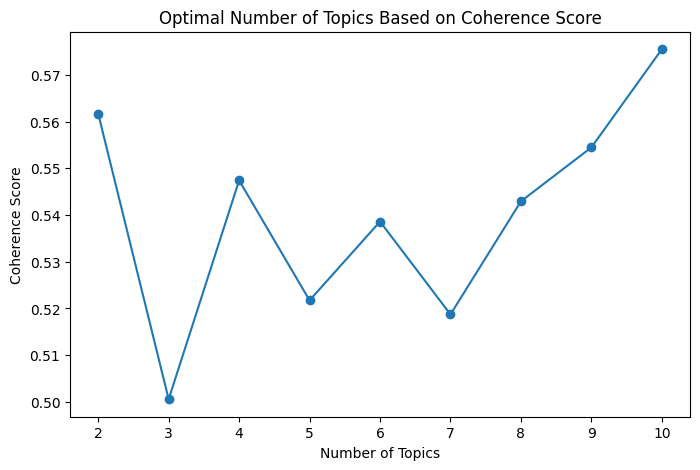

Number of Clusters: 2, Silhouette Score: 0.11184180180366143
Number of Clusters: 3, Silhouette Score: 0.12534406695555686
Number of Clusters: 4, Silhouette Score: 0.16265870413509542
Number of Clusters: 5, Silhouette Score: 0.16654160482500857
Number of Clusters: 6, Silhouette Score: 0.2022237497030568
Number of Clusters: 7, Silhouette Score: 0.2317356665362067
Number of Clusters: 8, Silhouette Score: 0.23655474021835868
Number of Clusters: 9, Silhouette Score: 0.27528576771490787
Number of Clusters: 10, Silhouette Score: 0.2911501034536892


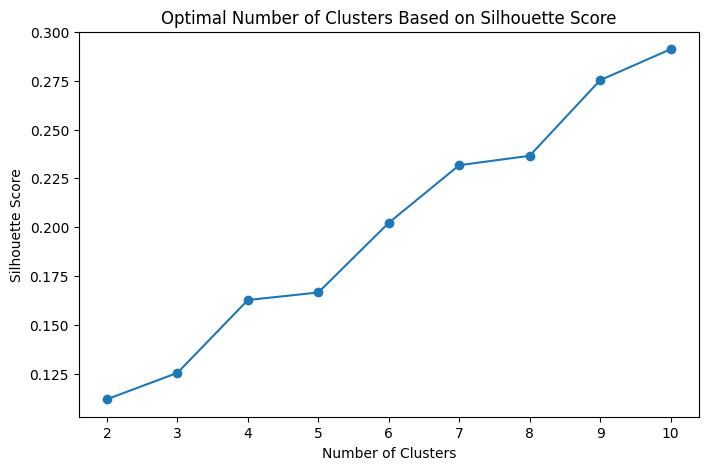

In [3]:
#LDA algorithm (probablistic model to generate topic and classifying words and documents into the topics)

# Apply preprocessing
processed_texts = text_data.apply(preprocess_text)

# TF-IDF Vectorization (A statistical formula to convert text documents into vectors based on the relevancy of the word.)
vectorizer = TfidfVectorizer(max_df=0.7, min_df=2) #Ignore terms that appear more than 70% of time time , consider only terms at least 2 document
tfidf_matrix = vectorizer.fit_transform(processed_texts) #The vectorizer step can be tuned denpending on theuser require ment


# Convert the TF-IDF matrix to gensim format for coherence scoring
texts = [text.split() for text in processed_texts] #Tokenised documents (form single words)
dictionary = Dictionary(texts) #package that maps each unique word to an integer ID
corpus = [dictionary.doc2bow(text) for text in texts] #each document is then represented as a bag of words format with Word ID and frequency

#Find Latent Dirichlet Allocation (LDA) coherence score --> used to evaluate the quality of the topic produced by LDA model
def lda_coherence_score(n_topics, corpus, dictionary, texts):
    lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, random_state=0)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

topic_range = range(2, 11)  # Testing topic numbers from 2 to 10
coherence_scores = []

for n_topics in topic_range:
    score = lda_coherence_score(n_topics, corpus, dictionary, texts)
    coherence_scores.append(score)
    print(f"Number of Topics: {n_topics}, Coherence Score: {score}")

# Plot Coherence Scores
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Optimal Number of Topics Based on Coherence Score')
plt.show()


cluster_range = range(2, 11)  # Testing cluster numbers from 2 to 10
silhouette_scores = []

for n_clusters in cluster_range: #Kmeans are used to group inputs into cluster base of TF-IDF matrix calculated above 
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of Clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")
    
#Silhouette Scores measures how well each data point fits within its assigned cluster compared to others.
#A higher score means clusters are distinct and well-defined, while a lower score suggests overlapping or poorly separated clusters.
# Plot Silhouette Scores 
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters Based on Silhouette Score')
plt.show()


We choose n_topics using the optimal number from the coherence score analysis. (Highest or plateaued). In this case we are choosing the optimal number 6 as it is a local maximum and i prefer a smaller topic for analysis due to our small data set.
Similar to n_topics we are using the optimal number from the silohuette score analysis. (Highest or plateaued) In this case we are choosing 10 clusters as it has the highest Silhouette Score.

We compile the results of our topic modeling and clustering into a DataFrame. For each document, we record the original text, preprocessed text, the most probable topic (from the LDA model), and the cluster label (from KMeans). This provides a dual categorization, capturing both main themes and group patterns within the data.

We save this DataFrame as "NLP_Analysis_Results.csv", creating an accessible file for further analysis, visualization, or reporting. This completes the analysis, making insights readily available for future use.

In [4]:
# Set the number of topics to identify
n_topics = 6  #Use the graph above to choose optimal n_topics
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_topics = lda_model.fit_transform(tfidf_matrix)

#Clustering with KMeans
n_clusters = 10  # Use the Graph above to choose optimal n-cluster ()
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(tfidf_matrix)

#\Compile Results into a DataFrame
results_df = pd.DataFrame({
    'Original Text': text_data,
    'Processed Text': processed_texts,
    'Topic': lda_topics.argmax(axis=1),  # Assign the most probable topic
    'Cluster': clusters  # Assign the cluster label
})

#Save Results to CSV for Analysis
results_df.to_csv("NLP_Analysis_Results.csv", index=False)
print("NLP analysis completed and saved to 'NLP_Analysis_Results.csv'")

results_df


NLP analysis completed and saved to 'NLP_Analysis_Results.csv'


,Original Text,Processed Text,Topic,Cluster
0,More frequent buses during exam periods,frequent buses exam periods,3,4
1,Bigger bus size,bigger bus size,4,1
3,More frequent buses to avoid overcrowding,frequent buses avoid overcrowding,0,4
4,better capacity management,better capacity management,4,3
5,More frequent buses,frequent buses,3,4
7,"MORE BUSES, it is always so crowded and squeez...",buses always crowded squeezy peak hours,0,2
8,more buses,buses,3,7
9,more buses and higher frequency especially dur...,buses higher frequency especially peak timings,0,2
10,increase the frequency of ISB services,increase frequency isb services,2,5
14,increase frequency of buses,increase frequency buses,2,5


This code snippet performs sentiment analysis on the processed text data using TextBlob. For each document in processed_texts, we calculate a sentiment polarity score, which ranges from -1 to 1, where scores near 1 indicate positive sentiment, scores near -1 indicate negative sentiment, and scores around 0 suggest neutral sentiment. We then add these scores as a new column, Sentiment Score, to the results_df DataFrame. This addition enriches our analysis by providing insight into the emotional tone of each document, complementing the thematic topics and clusters already identified, and offering a fuller understanding of the text data.

In [5]:

# Sentiment Analysis with TextBlob
sentiment_scores = processed_texts.apply(lambda x: TextBlob(x).sentiment.polarity)
#package have build in dictionary to sentiment grouper

# Add sentiment scores to the results DataFrame
results_df['Sentiment Score'] = sentiment_scores

results_df


,Original Text,Processed Text,Topic,Cluster,Sentiment Score
0,More frequent buses during exam periods,frequent buses exam periods,3,4,0.100000
1,Bigger bus size,bigger bus size,4,1,0.000000
3,More frequent buses to avoid overcrowding,frequent buses avoid overcrowding,0,4,0.100000
4,better capacity management,better capacity management,4,3,0.500000
5,More frequent buses,frequent buses,3,4,0.100000
7,"MORE BUSES, it is always so crowded and squeez...",buses always crowded squeezy peak hours,0,2,0.000000
8,more buses,buses,3,7,0.000000
9,more buses and higher frequency especially dur...,buses higher frequency especially peak timings,0,2,0.125000
10,increase the frequency of ISB services,increase frequency isb services,2,5,0.000000
14,increase frequency of buses,increase frequency buses,2,5,0.000000



This code then generates three visualizations to provide insights into the distribution of topics, clusters, and sentiment scores in the text data. In the first visualization, we create a bar chart showing the distribution of topics by counting how many documents are assigned to each topic in the results_df DataFrame. This reveals the prevalence of each topic, highlighting which themes are most and least common in the data. In the second visualization, we plot a similar bar chart for the distribution of clusters, which shows the number of documents within each KMeans cluster, offering insight into the clustering patterns and relative sizes of each cluster. Finally, if sentiment analysis was conducted, the third visualization displays a histogram of sentiment scores, illustrating the frequency of different sentiment levels across the dataset. This provides an overview of the emotional tone, showing whether the text data skews more positive, negative, or neutral. Together, these visualizations allow for a comprehensive view of the thematic, structural, and emotional distribution in the text data.

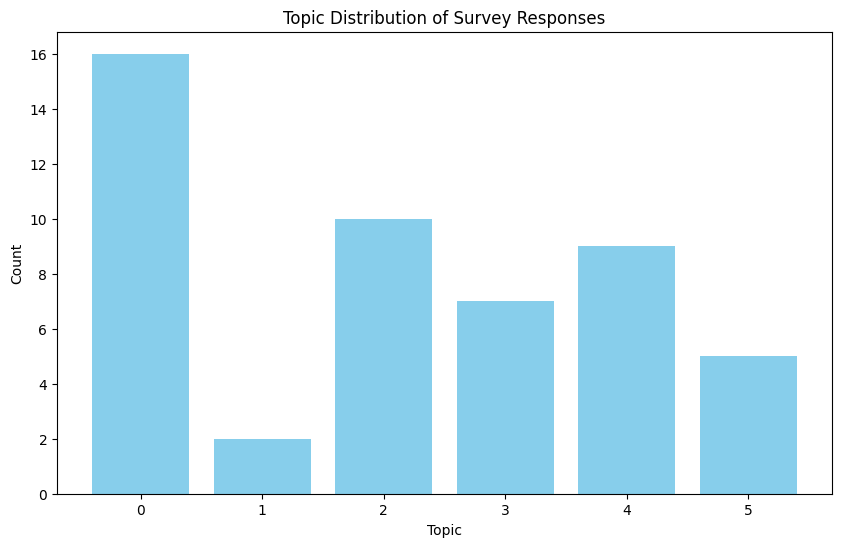

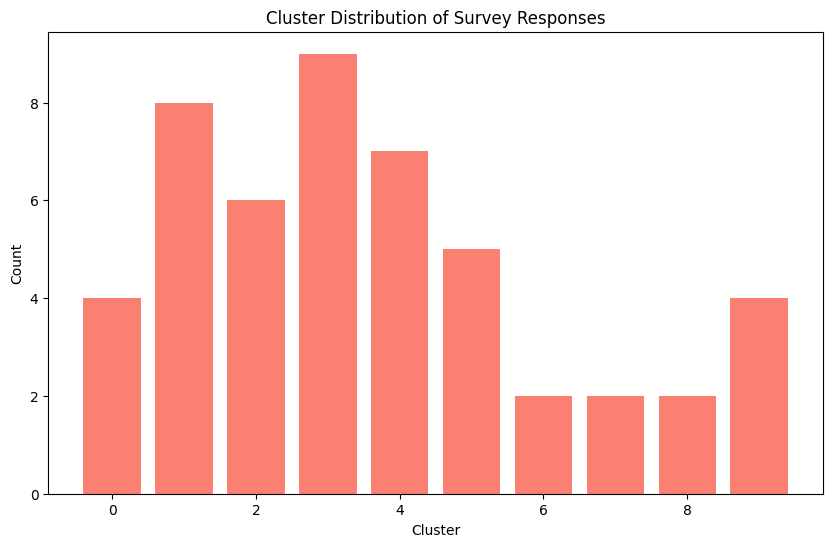

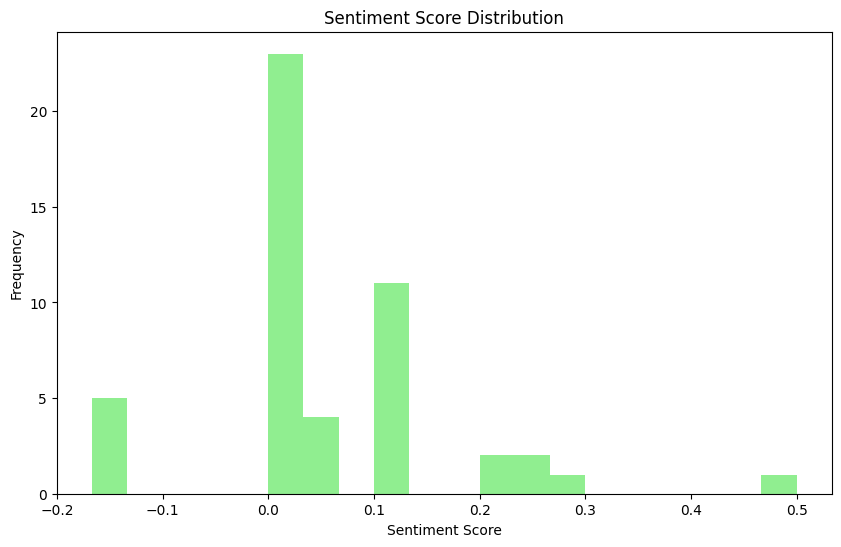

In [6]:
# Visualization 1: Topic Distribution
topic_counts = results_df['Topic'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(topic_counts.index, topic_counts.values, color='skyblue')
plt.title("Topic Distribution of Survey Responses")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.show()

# Visualization 2: Cluster Distribution
cluster_counts = results_df['Cluster'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='salmon')
plt.title("Cluster Distribution of Survey Responses")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# Visualization 3: Sentiment Analysis (if sentiment is included)
if 'Sentiment Score' in results_df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(results_df['Sentiment Score'], bins=20, color='lightgreen')
    plt.title("Sentiment Score Distribution")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.show()


The first bar chart shows how the documents are distributed across different topics. Topic 3 has the highest count, indicating that it is the most prevalent theme within the dataset. Topics 0 and 5 also have a relatively strong presence, while Topic 1 has the fewest entries, suggesting it is the least common theme. This distribution gives us an idea of the dominant themes and less represented ones, highlighting areas where responses are more concentrated.

In the second bar chart, we observe the distribution of documents across clusters. Cluster 1 has the highest number of entries, followed by clusters 2, 5, and 6, while clusters 0, 4, and 7 have fewer entries. This suggests that certain clusters capture larger groups of documents with similar characteristics, while others represent smaller or more distinct segments within the dataset. The varying sizes of clusters indicate diverse groupings and similarity patterns among the documents.

The histogram of sentiment scores shows the emotional tone across documents. Most sentiment scores are close to 0, indicating a largely neutral tone in the dataset. There is a slight skew towards positive sentiment, with several scores around 0.1 and a few up to 0.5. A few negative scores are present as well, but they are less frequent. This distribution suggests that while most responses are neutral, there is a mild tendency towards positive sentiment, with few responses expressing negative tones.

KMeans groups documents by similarity, helping to organize documents into clusters of similar content for easy categorization.
LDA reveals hidden topics within documents, allowing us to understand underlying themes or subjects across the entire dataset.